In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

dframe = pd.read_csv('C:/Users/Ukrai/Desktop/JeepWrangCSV.csv', sep='[;,]', engine='python')
dframe=dframe.drop_duplicates(subset=['VIN'])
dframe=dframe[['Price','Auction','ProductionDate','Condition','Milage','PrimaryDamage','SecondaryDamage','Gearbox','DriveUnit','Keys']].fillna(0).reset_index(drop=True)
qwet=0
for it in dframe.Milage:
    qwt = [int(wt) for wt in it.split() if wt.isdigit()]
    if not qwt:
        dframe.at[qwet,'Milage']=float(0.0)
    else:
        dframe.at[qwet,'Milage']=float(qwt[0])
    qwet+=1
#####
asq=0
while asq<len(dframe.Price):
    if dframe.Price.iloc[asq]<5000:
        dframe.Price.loc[asq]=5000
    elif 5000<dframe.Price.iloc[asq]<10000:
        dframe.Price.loc[asq]=10000
    elif 10000<dframe.Price.iloc[asq]<15000:
        dframe.Price.loc[asq]=15000
    elif 15000<dframe.Price.iloc[asq]<20000:
        dframe.Price.loc[asq]=20000
    else:
        dframe.Price.loc[asq]=25000
    asq+=1

dframe.head(3)

,Price,Auction,ProductionDate,Condition,Milage,PrimaryDamage,SecondaryDamage,Gearbox,DriveUnit,Keys
0,10000,IAAI,2008,Stationary,0,Unknown,Не указано,Manual,4X4 Drive,Present
1,15000,IAAI,2018,Stationary,50327,Rollover,Не указано,Automatic,4X4 Drive,Present
2,5000,IAAI,2008,Run and Drive,110350,Roof,Right Side,Manual,4X4 Drive,Present


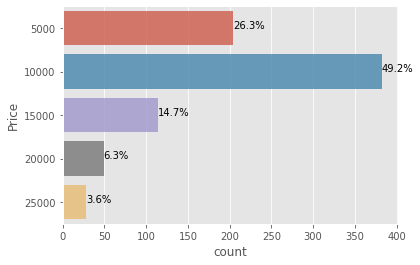

In [2]:
ax = sns.countplot(y="Price", data=dframe, alpha=0.8)
total = dframe.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.show()

In [3]:
dframe.dtypes

Price               int64
Auction            object
ProductionDate      int64
Condition          object
Milage             object
PrimaryDamage      object
SecondaryDamage    object
Gearbox            object
DriveUnit          object
Keys               object
dtype: object

In [4]:
dframe.isna().mean()*100

Price              0.0
Auction            0.0
ProductionDate     0.0
Condition          0.0
Milage             0.0
PrimaryDamage      0.0
SecondaryDamage    0.0
Gearbox            0.0
DriveUnit          0.0
Keys               0.0
dtype: float64

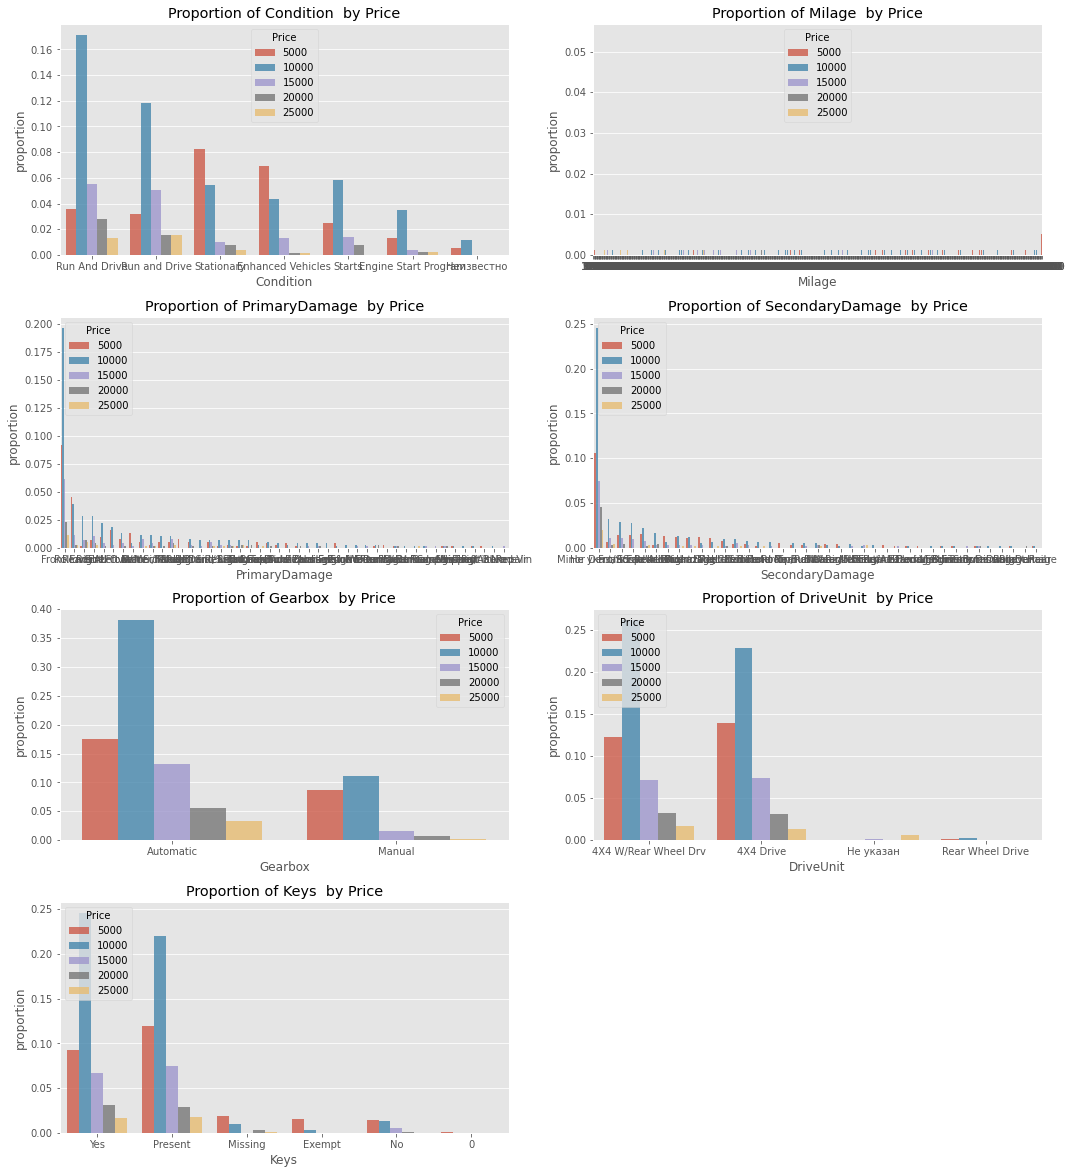

In [5]:
cols_obj = list(dframe.dtypes[dframe.dtypes == object].index[1:])
plt.figure(figsize=[15, 20])

i = 1
y, hue = "proportion", "Price"

for f in cols_obj:
    plt.subplot(5, 2, i)
    dframe[[f, 'Price']]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, "data"), x=f, y='proportion', hue='Price', alpha=0.8)
    plt.title("Proportion of {}  by Price".format(f))
    i += 1
plt.tight_layout()
plt.show()
#По некоторым графикам заметно что хвосты не чищены и некоторая информация дублируется (но мы просто играемся с моделью)
#рассеиваие сильное будет устраиваться наличием первичного и вторичного повреждения. при посмотрении можно и убрать т.к. они не сильно влияют,
#но есть большинство авто что бьётся в "морду"
#мили тоже могут испортить картинку

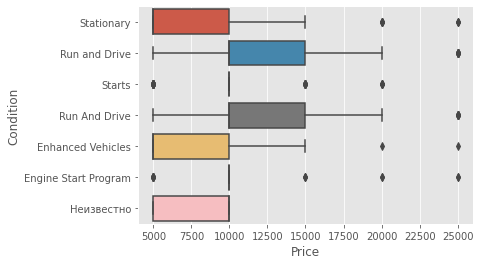

In [6]:
sns.boxplot(x='Price', y='Condition', data=dframe)
plt.show()
#Можно дополнительно проверить на зваимосвязь между переменными составляющими стоимость, но сразу поиграемся с моделями

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

X = pd.get_dummies(dframe).drop('Price', axis=1)
Y = dframe['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
#print(X_train.shape)
#print(X_test.shape)

models = []
models.append(("Logistic Regression:",LogisticRegression()))
models.append(("Naive Bayes:",GaussianNB()))
models.append(("K-Nearest Neighbour:",KNeighborsClassifier(n_neighbors=3)))
models.append(("Decision Tree:",DecisionTreeClassifier()))
models.append(("Support Vector Machine-linear:",SVC(kernel="linear")))
models.append(("Support Vector Machine-rbf:",SVC(kernel="rbf")))
models.append(("Random Forest:",RandomForestClassifier(n_estimators=7)))
models.append(("Xtreme Gradient Boost:",XGBClassifier()))
models.append(("MLP:",MLPClassifier(hidden_layer_sizes=(45,30,15),solver='sgd',learning_rate_init=0.01,max_iter=500)))
models.append(("AdaBoostClassifier:",AdaBoostClassifier()))
models.append(("GradientBoostingClassifier:",GradientBoostingClassifier()))

results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=0)
    cv_result = cross_val_score(model,X_train,Y_train.values.ravel(), cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
    print('%s: %f (%f)' % (name, cv_result.mean(), cv_result.std()))
for i in range(len(names)):
    print(names[i],results[i].mean()*100)

Logistic Regression:: 0.491987 (0.084639)
Naive Bayes:: 0.119663 (0.037074)
K-Nearest Neighbour:: 0.536128 (0.089487)
Decision Tree:: 0.574848 (0.060027)
Support Vector Machine-linear:: 0.598721 (0.073527)
Support Vector Machine-rbf:: 0.491953 (0.054115)
Random Forest:: 0.530673 (0.069430)
[13:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/le

In [14]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [15]:
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X, Y)
report_best_scores(search.cv_results_, 1)

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)
display_scores(np.sqrt(-scores))
##########################broken

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 11.3min finished


Model with rank: 1
Mean validation score: 0.576 (std: 0.078)
Parameters: {'colsample_bytree': 0.9519366578369711, 'gamma': 0.43349688000576175, 'learning_rate': 0.15239534860945342, 'max_depth': 2, 'n_estimators': 102, 'subsample': 0.6924299186352285}



ValueError: Found input variables with inconsistent numbers of samples: [777, 10]